# NLP Automatic Ticket Assignment Project


# Step 1 : Importing Dependencies

In [84]:
# !pip install chart_studio
# !pip install wordcloud
# !pip install ftfy
# !pip install lightgbm

# Standard Library
import pandas as pd
import numpy as np

from ftfy import *
import nltk

from utils.visualization import *
from utils.datapreprocessing import *

import missingno as msno
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns 

# For Translation
from googletrans import Translator
from langdetect import detect

# For LDA
from gensim.models.ldamulticore import LdaMulticore

# Step 2. Importing Data and performing basic EDA

In [85]:
filename= "dataset/input_data.xlsx"
df = pd.read_excel(filename, lines=True)

In [86]:
df.head(5)

Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1  \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...  hmjdrvpb komuaywn   
2  \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group  
0            GRP_0  
1            GRP_0  
2            GRP_0  
3            GRP_0  
4            GRP_0

In [87]:
df.count()

Short description    8492
Description          8499
Caller               8500
Assignment group     8500
dtype: int64

In [88]:
# Convert datatype to string
# df = df.applymap(str)
# df.count()

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


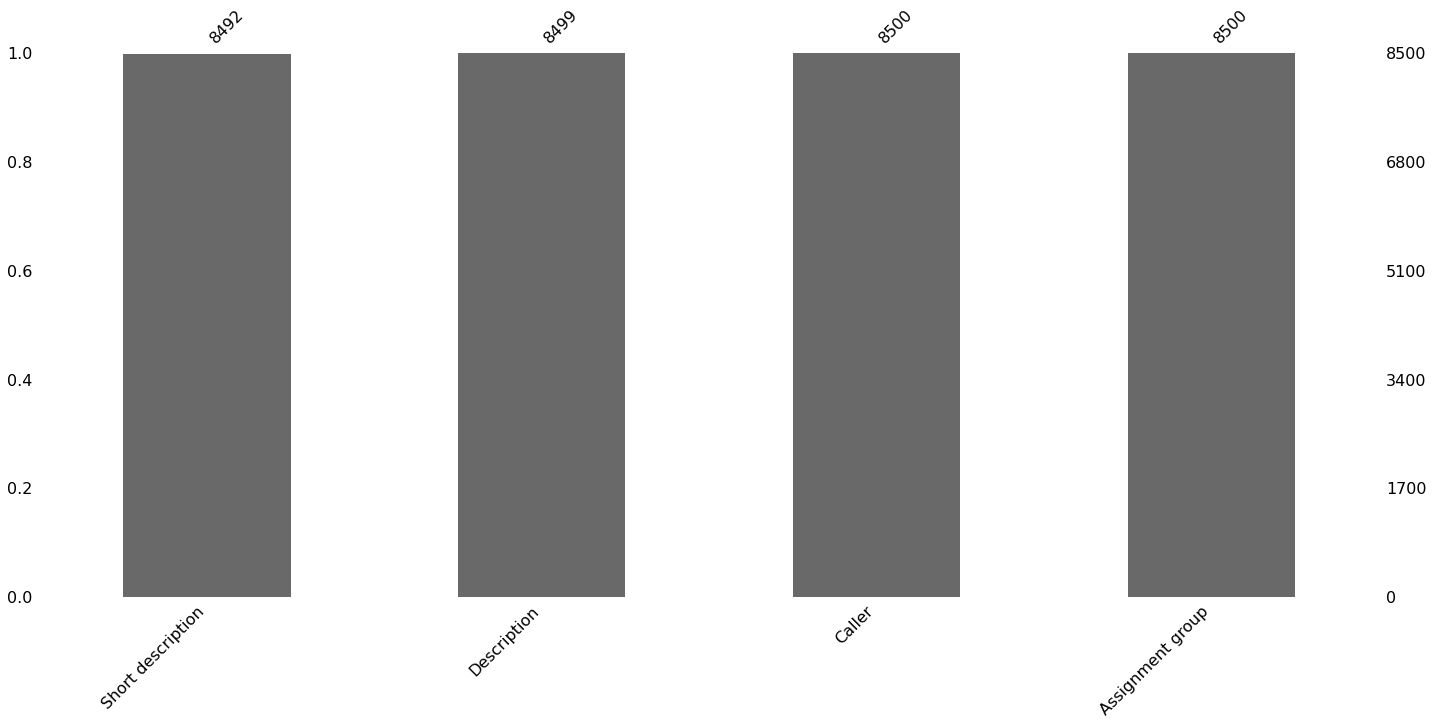

In [90]:
msno.bar(df)

## NOTE : There are 8 NaN Values in 'Short description' Feature, and 1 NaN value in 'Description' Feature.

In [91]:
df['Assignment group'].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_70       1
GRP_35       1
GRP_67       1
GRP_61       1
GRP_73       1
Name: Assignment group, Length: 74, dtype: int64

## NOTE : There are 74 Dependent/Target classes which are required to be predicted by our Model

# Step 3 : Finding and Treating Missing Values using Rake

## 3(a). Finding NaN Values in 'Short Description' and 'Description'

In [92]:
# For Short Description
df[df['Short description'].isnull()][['Short description', 'Description']]

Short description                                        Description
2604               NaN  \r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...
3383               NaN  \r\n-connected to the user system using teamvi...
3906               NaN  -user unable  tologin to vpn.\r\n-connected to...
3910               NaN  -user unable  tologin to vpn.\r\n-connected to...
3915               NaN  -user unable  tologin to vpn.\r\n-connected to...
3921               NaN  -user unable  tologin to vpn.\r\n-connected to...
3924               NaN  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...
4341               NaN  \r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...

In [93]:
# For Description
df[df['Description'].isnull()][['Short description', 'Description']]

Short description Description
4395  i am locked out of skype         NaN

## 3(b). Importing and implementing RAKE(Rapid Automatic Keyword Extraction algorithm) for extracting Key phrases
---------------
* Rake extract Key phrases in a body of text by analyzing the frequency of word appearance and its co-occurance with other words in the text. 

* We will group rows of simillar Key phrases and fill missing NaN values from its simillar rows

In [94]:
r = Rake()

In [95]:
# Imputing NaN values in 'Short description' based upon corresponding 'Description' values from other simillar rows in df
df.at[2604, 'Short description'] = 'NaN'
df.at[3383, 'Short description'] = 'NaN'
df.at[3906, 'Short description'] = 'NaN'
df.at[3910, 'Short description'] = 'NaN'
df.at[3915, 'Short description'] = 'NaN'
df.at[3921, 'Short description'] = 'NaN'
df.at[3924, 'Short description'] = 'NaN'
df.at[4341, 'Short description'] = 'NaN'

# Imputing NaN values in 'Description' based upon corresponding 'Description' values from other simillar rows in df
df.at[4395, 'Description'] = 'NaN'

### Implimenting and Extracting Key Phrases in 'Description' and 'Short description'
-----------

In [96]:
df['Raked Short description'] = df['Short description'].apply(rake_implement)
df['Raked Description'] = df['Description'].apply(rake_implement)

### Key Phrases(od Description) for rows with missing Short description values
------

In [97]:
for i in df[df['Short description'] == 'NaN']['Raked Description']:
    print(i, "\n")

['kindly resolve yhe issue', 'urgent basis', 'com hi', 'working', 'rezuibdt', 'received', 'ohdrnswl', 'link', 'gmail', 'best'] 

['user system using teamviewer', 'user login', 'issue resolved', 'portal', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['microsoft internet explorer email', 'happen please help aerp', 'com customer number', 'wvqgbdhm fwchqjor language', 'te

### Corresponding 'Description values' for NaN 'Short description' rows

In [98]:
for ind in [2604, 3383, 3906, 3910, 3915, 3921, 3924, 4341]:
    print("---"*3, "Row Id ", ind, "---"*3)
    print(df.iloc[ind, 1], "\n")

--------- Row Id  2604 ---------


received from: ohdrnswl.rezuibdt@gmail.com

hi,



link is not working. kindly resolve yhe issue on urgent basis.



best  

--------- Row Id  3383 ---------

-connected to the user system using teamviewer.
-help the user login to the portal.
-issue resolved. 

--------- Row Id  3906 ---------
-user unable  tologin to vpn.
-connected to the user system using teamviewer.
-help the user login to the company vpn using the vpn company vpn link.
-issue resolved. 

--------- Row Id  3910 ---------
-user unable  tologin to vpn.
-connected to the user system using teamviewer.
-help the user login to the company vpn using the vpn company vpn link.
-issue resolved. 

--------- Row Id  3915 ---------
-user unable  tologin to vpn.
-connected to the user system using teamviewer.
-help the user login to the company vpn using the vpn company vpn link.
-issue resolved. 

--------- Row Id  3921 ---------
-user unable  tologin to vpn.
-connected to the user system usin

### Corresponding 'Short description values' for NaN 'Description' rows

In [99]:
print("---"*3, "Row Id 4395", "---"*3)
print(df.iloc[4395, 0], "\n")

--------- Row Id 4395 ---------
i am locked out of skype 



## 3(b). Replacing NaN Values in 'Short Description' and 'Description' with simillar values from other rows

In [100]:
# Imputing NaN values in 'Short description' based upon corresponding 'Description' values from other simillar rows in df
df.at[2604, 'Short description'] = 'link not working'
df.at[3383, 'Short description'] = 'login issue'
df.at[3906, 'Short description'] = 'vpn login issue'
df.at[3910, 'Short description'] = 'vpn login issue'
df.at[3915, 'Short description'] = 'vpn login issue'
df.at[3921, 'Short description'] = 'vpn login issue'
df.at[3924, 'Short description'] = 'vpn login issue'
df.at[4341, 'Short description'] = 'login failure erp'

# Imputing NaN values in 'Description' based upon corresponding 'Description' values from other simillar rows in df
df.at[4395, 'Description'] = 'i am locked out of skype'

print("Succesfully replaced all NaN values in NaN Values in 'Short Description' and 'Description' feature.")

Succesfully replaced all NaN values in NaN Values in 'Short Description' and 'Description' feature.


In [101]:
df.count().T

Short description          8500
Description                8500
Caller                     8500
Assignment group           8500
Raked Short description    8500
Raked Description          8500
dtype: int64

## NOTE : We can verify that there are no more missing values in any of the features.

# Step 4 : Data Cleaning : Fixing Garbled Text/ Mojibake/Replacing Contractions and Lemmitization
------------------
### The most interesting kind of brokenness that ftfy will fix is when someone has encoded Unicode with one standard and decoded it with a different one. This often shows up as characters that turn into nonsense sequences (called “mojibake”)

## 5(a). Garbled Text/ Mojibake

In [102]:

# Before cleaning Garbled Text/Mojibakes with ftfy
df['Description'][164]

'\n\nreceived from: abcdri@company.com\n\nwindy shi å°†æ’¤å›žé‚®ä»¶"ticket_no1564867 -- comments added"ã€‚\n\n\næœ¬è®¯æ\x81¯ä»…ä¾›æŒ‡å®šçš„æŽ¥æ”¶äººä½¿ç”¨ï¼Œå…¶ä¸\xadå\x8f¯èƒ½åŒ…å\x90«é€‚ç”¨æ³•å¾‹é¡¹ä¸‹ç‰¹è®¸çš„ã€\x81ä¿\x9då¯†çš„å’Œç¦\x81æ\xad¢æŠ«éœ²çš„å†…å®¹ã€‚é™¤æŒ‡å®šçš„æŽ¥æ”¶äººå¤–ï¼Œä¸¥ç¦\x81å…¶ä»–ä»»ä½•äººä¼\xa0æ’\xadã€\x81åˆ†å\x8f‘æˆ–å¤\x8dåˆ¶æœ¬è®¯æ\x81¯ã€‚å¦‚æžœæ‚¨è¯¯æ”¶åˆ°æœ¬è®¯æ\x81¯ï¼Œè¯·é€šçŸ¥å\x8f‘ä»¶äººå¹¶å°†è®¯æ\x81¯åˆ\xa0é™¤ã€‚\n[\nselect the following link to view the disclaimer in an alternate language. '

In [103]:
### Applying ftfy.fix_text 
df['Short description'] = df['Short description'].apply(fix_text)
df['Description'] = df['Description'].apply(fix_text)
print("'Short description' and 'Description' Raking is complete.")

'Short description' and 'Description' Raking is complete.


## 5(b). Applying Lemmitization & Stemming and Replacing Contractions

In [104]:
for short_des in df['Short description']:
    short_des = clean_text(short_des)
print("'Short description' cleaning is complete.")

'Short description' cleaning is complete.


In [105]:
for des in df['Description']:
    des = clean_text(des)
print("'Description' Cleaning is complete.")

'Description' Cleaning is complete.


In [106]:
# Clean dataset cloumn Complete_Description

#cleanDataset(df, 'Short description', getRegexList())
#cleanDataset(df, 'Description', getRegexList())
#cleanDataset(df, 'Complete_Description', getRegexList())

# Performing a Regex_clean is causing many data to be dropped. HTML Characters/ Non standard syntax and vocabulary characters or words Later

### Checking Data after ftfy/Contraction replacement and Lemmitization

In [107]:
# After cleaning Garbled Text/Mojibakes with ftfy.fix_text
df['Description'][164]

'\n\nreceived from: abcdri@company.com\n\nwindy shi 将撤回邮件"ticket_no1564867 -- comments added"。\n\n\n本讯息仅供指定的接收人使用,其中可能包含适用法律项下特许的、保密的和禁止披露的内容。除指定的接收人外,严禁其他任何人传播、分发或复制本讯息。如果您误收到本讯息,请通知发件人并将讯息删除。\n[\nselect the following link to view the disclaimer in an alternate language. '

In [108]:
df['Description'].head(20)

0     -verified user details.(employee# & manager na...
1     \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...
2     \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...
3                         unable to access hr_tool page
4                                          skype error 
5        unable to log in to engineering tool and skype
6     event: critical:HostName_221.company.com the v...
7     ticket_no1550391- employment status - new non-...
8                  unable to disable add ins on outlook
9                       ticket update on inplant_874773
10    engineering tool says not connected and unable...
11              hr_tool site not loading page correctly
12    unable to login to hr_tool to sgxqsuojr xwbeso...
13                     user wants to reset the password
14                             unable to open payslips 
15                      ticket update on inplant_874743
16    \n\nreceived from: xyz@company.com\n\nhi,\n\ni...
17        when undocking pc , screen will not co

## NOTE : We can see that apart from English there are many non-english data points. The objective of the next step is to treat the non English language objects in df.(yet to be done)

## NOTE : We can see many non english noise in data, but we will do a second stage text filtering after translation is done, because many of the non english data will be dropped after being mistakened as noise. 

# Step 5 : Translation

In [109]:
# Inputting Path
filename= "dataset/translated_input_data.csv"

# Importing CSV as df
vaishakh_df = pd.read_csv(filename)

#Renaming Columns
vaishakh_df.columns = ['Short description', 'Description', 'Caller', 'Assignment group', 'Iso_Description', 'Language_Description', 'Translated_Description', 'Iso_Short description', 'Language_Short description', 'Translated_Short description']

In [110]:
vaishakh_df.head()

Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1    received from: hmjdrvpb.komuaywn@gmail.com  ...  hmjdrvpb komuaywn   
2    received from: eylqgodm.ybqkwiam@gmail.com  ...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group Iso_Description Language_Description  \
0            GRP_0              en              English   
1            GRP_0              en              English   
2            GRP_0              en              English   
3            GRP_0              en              English   
4            GRP_0              ja             Japanese   

                              Translated_Description Iso_Short description  \
0  -verified user details.(employee# & manager na...                    en   
1    received from: hmjdrvpb.komuaywn@gmail.com  ...                    en   
2    received from: eylqgodm.ybqkwiam@gmail.com  ...                    en   
3                      unable to access hr_tool page                    en   
4                                        skype error                    ja   

  Language_Short description   Translated_Short description  
0                    English                    login issue  
1                    English                        outlook  
2                    English             cant log in to vpn  
3                    English  unable to access hr_tool page  
4                   Japanese                    skype error

In [111]:
vaishakh_df.head(5)

Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1    received from: hmjdrvpb.komuaywn@gmail.com  ...  hmjdrvpb komuaywn   
2    received from: eylqgodm.ybqkwiam@gmail.com  ...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group Iso_Description Language_Description  \
0            GRP_0              en              English   
1            GRP_0              en              English   
2            GRP_0              en              English   
3            GRP_0              en              English   
4            GRP_0              ja             Japanese   

                              Translated_Description Iso_Short description  \
0  -verified user details.(employee# & manager na...                    en   
1    received from: hmjdrvpb.komuaywn@gmail.com  ...                    en   
2    received from: eylqgodm.ybqkwiam@gmail.com  ...                    en   
3                      unable to access hr_tool page                    en   
4                                        skype error                    ja   

  Language_Short description   Translated_Short description  
0                    English                    login issue  
1                    English                        outlook  
2                    English             cant log in to vpn  
3                    English  unable to access hr_tool page  
4                   Japanese                    skype error

In [112]:
vaishakh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Short description             8492 non-null   object
 1   Description                   8499 non-null   object
 2   Caller                        8500 non-null   object
 3   Assignment group              8500 non-null   object
 4   Iso_Description               8500 non-null   object
 5   Language_Description          8500 non-null   object
 6   Translated_Description        8499 non-null   object
 7   Iso_Short description         8500 non-null   object
 8   Language_Short description    8500 non-null   object
 9   Translated_Short description  8492 non-null   object
dtypes: object(10)
memory usage: 664.2+ KB


In [113]:
translated_df = pd.concat([df, vaishakh_df.drop(['Short description', 'Description', 'Caller', 'Assignment group'], axis=1)], axis=1)

In [114]:
translated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Short description             8500 non-null   object
 1   Description                   8500 non-null   object
 2   Caller                        8500 non-null   object
 3   Assignment group              8500 non-null   object
 4   Raked Short description       8500 non-null   object
 5   Raked Description             8500 non-null   object
 6   Iso_Description               8500 non-null   object
 7   Language_Description          8500 non-null   object
 8   Translated_Description        8499 non-null   object
 9   Iso_Short description         8500 non-null   object
 10  Language_Short description    8500 non-null   object
 11  Translated_Short description  8492 non-null   object
dtypes: object(12)
memory usage: 797.0+ KB


In [115]:
translated_df.head(5)

Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1  \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
2  \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group        Raked Short description  \
0            GRP_0                  [login issue]   
1            GRP_0                      [outlook]   
2            GRP_0                [cant log, vpn]   
3            GRP_0  [access hr_tool page, unable]   
4            GRP_0                  [skype error]   

                                   Raked Description Iso_Description  \
0  [verified user details, user name, manager nam...              en   
1  [somebody please advise, com hello team, skype...              en   
2  [vpn best, com hi, cannot log, ybqkwiam, recei...              en   
3                      [access hr_tool page, unable]              en   
4                                      [skype error]              ja   

  Language_Description                             Translated_Description  \
0              English  -verified user details.(employee# & manager na...   
1              English    received from: hmjdrvpb.komuaywn@gmail.com  ...   
2              English    received from: eylqgodm.ybqkwiam@gmail.com  ...   
3              English                      unable to access hr_tool page   
4             Japanese                                        skype error   

  Iso_Short description Language_Short description  \
0                    en                    English   
1                    en                    English   
2                    en                    English   
3                    en                    English   
4                    ja                   Japanese   

    Translated_Short description  
0                    login issue  
1                        outlook  
2             cant log in to vpn  
3  unable to access hr_tool page  
4                    skype error

## 5(a). Detecting and translating the language in "Short_description" features

In [116]:
#df['Translated Short description'] = df['Short description']

In [117]:
'''
for i in range(0,df.shape[0]):
    try:
        Short_description_language = detect(str(df['Short description'][i]))
        if detect(str(df['Short description'][i])) != 'en':
            df['Translated Short description'][i] = Translator().translate(str(df['Short description'][i]),
                                                                            src= Short_description_language,
                                                                            dest='en').text
        else:
            df['Translated Short description'][i] = str(df['Short description'][i])
    except:
        print("This row throws and error:", i)
        df['Translated Short description'][i] = str(df['Short description'][i])
'''

'\nfor i in range(0,df.shape[0]):\n    try:\n        Short_description_language = detect(str(df[\'Short description\'][i]))\n        if detect(str(df[\'Short description\'][i])) != \'en\':\n            df[\'Translated Short description\'][i] = Translator().translate(str(df[\'Short description\'][i]),\n                                                                            src= Short_description_language,\n                                                                            dest=\'en\').text\n        else:\n            df[\'Translated Short description\'][i] = str(df[\'Short description\'][i])\n    except:\n        print("This row throws and error:", i)\n        df[\'Translated Short description\'][i] = str(df[\'Short description\'][i])\n'

In [118]:

print("German (Before Translation):", translated_df['Short description'][1622])
print('\nEnglish (After Translation): ', translated_df['Translated_Short description'][1622])

German (Before Translation): nachdem ich outlook geöffnet habe und eine e-mail angeklickt habe kommt ein blauer kreis der sich dreht und ich nichts 

English (After Translation):  after I open outlook and have an e-mail clicked is a blue circle rotates and I nothing


In [119]:
print("Chinese (Before Translation):",translated_df['Short description'][164])
print('\nEnglish (After Translation): '+translated_df['Translated_Short description'][164])

Chinese (Before Translation): 撤回: ticket_no1564867 -- comments added

English (After Translation): 撤回: ticket_no1564867 -- comments added


## 5(b). Detecting and translating the language in "Description" features

In [120]:
#df['Translated Description'] = df['Description']

In [121]:
'''
for i in range(0,df.shape[0]):
    Description_lang = detect(str(df['Description'][i]))
    try:
        if Description_lang != 'en' : #de
            df['Translated Description'][i] = Translator().translate(str(df['Description'][i]),src= Description_lang, dest='en').text
            print("Current Time for Row Id ", i, "with Language ",Description_lang," is: ", current_time)
        else:
            df['Translated Description'][i] = str(df['Description'][i])
    except:
        print("This row throws and error:", i)
        df['Translated Description'][i] = str(df['Description'][i])
'''

'\nfor i in range(0,df.shape[0]):\n    Description_lang = detect(str(df[\'Description\'][i]))\n    try:\n        if Description_lang != \'en\' : #de\n            df[\'Translated Description\'][i] = Translator().translate(str(df[\'Description\'][i]),src= Description_lang, dest=\'en\').text\n            print("Current Time for Row Id ", i, "with Language ",Description_lang," is: ", current_time)\n        else:\n            df[\'Translated Description\'][i] = str(df[\'Description\'][i])\n    except:\n        print("This row throws and error:", i)\n        df[\'Translated Description\'][i] = str(df[\'Description\'][i])\n'

In [122]:

print("German (Before Translation):",translated_df['Description'][1622])
print('\nEnglish (After Translation): '+translated_df['Translated_Description'][1622])

German (Before Translation): mehr machen. bitte dringend um hilfe. meine mobile tel. nr. 

English (After Translation): make more. Please urgently for help. my mobile tel. No.


In [123]:
print("Chinese (Before Translation):",translated_df['Description'][164])
print('\nEnglish (After Translation): '+translated_df['Translated_Description'][164])

Chinese (Before Translation): 

received from: abcdri@company.com

windy shi 将撤回邮件"ticket_no1564867 -- comments added"。


本讯息仅供指定的接收人使用,其中可能包含适用法律项下特许的、保密的和禁止披露的内容。除指定的接收人外,严禁其他任何人传播、分发或复制本讯息。如果您误收到本讯息,请通知发件人并将讯息删除。
[
select the following link to view the disclaimer in an alternate language. 

English (After Translation): received from: abcdri@company.com windy shi will recall message "ticket_no1564867 - comments added". This message is for the designated recipient to use, which may contain privileged under applicable law, confidentiality and non-disclosure of content. In addition to the designated recipient, any other person is strictly prohibited dissemination, distribution or copying of this message. If you receive this message by mistake, please notify the sender and delete the message. [Select the following link to view the disclaimer in an alternate language.


## 5(c). Findind and fixing missing values in translated data i.e. translated_df
---------------
-> 8 Values are missing in Tranlated_Short description <br>
-> 1 Value is missing in translated_Description <br>
-> All the values missing are in english language <br>
-> We will simply copy the corresponding original values

In [124]:
# For Translated Short Description we can see the respective row values are in english
translated_df[translated_df['Translated_Short description'].isnull()][['Short description', 'Description','Translated_Description']]

Short description                                        Description  \
2604   link not working  \n\nreceived from: ohdrnswl.rezuibdt@gmail.com...   
3383        login issue  \n-connected to the user system using teamview...   
3906    vpn login issue  -user unable  tologin to vpn.\n-connected to t...   
3910    vpn login issue  -user unable  tologin to vpn.\n-connected to t...   
3915    vpn login issue  -user unable  tologin to vpn.\n-connected to t...   
3921    vpn login issue  -user unable  tologin to vpn.\n-connected to t...   
3924    vpn login issue  name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...   
4341  login failure erp  \n\nreceived from: eqmuniov.ehxkcbgj@gmail.com...   

                                 Translated_Description  
2604    received from: ohdrnswl.rezuibdt@gmail.com  ...  
3383   -connected to the user system using teamviewe...  
3906  -user unable  tologin to vpn. -connected to th...  
3910  -user unable  tologin to vpn. -connected to th...  
3915  -user unable  tologin to vpn. -connected to th...  
3921  -user unable  tologin to vpn. -connected to th...  
3924  name:wvqgbdhm fwchqjor language: browser:micro...  
4341    received from: eqmuniov.ehxkcbgj@gmail.com  ...

In [125]:
# For 'Translated_Description' we can see the respective row values are in english
translated_df[translated_df['Translated_Description'].isnull()][['Short description', 'Translated_Short description', 'Description']]

Short description Translated_Short description  \
4395  i am locked out of skype     i am locked out of skype   

                   Description  
4395  i am locked out of skype

In [126]:
# Copying values from 'Short description' which are already correctly imputated
translated_df["Translated_Short description"] = translated_df["Translated_Short description"].fillna(translated_df["Short description"])
print("Succesfully filled all NaN values in 'Translated_Short description'")

Succesfully filled all NaN values in 'Translated_Short description'


In [127]:
# Copying values from 'Description' which are already correctly imputated
translated_df["Translated_Description"] = translated_df["Translated_Description"].fillna(translated_df["Description"])
print("Succesfully filled all NaN values in 'Translated_Description'")

Succesfully filled all NaN values in 'Translated_Description'


In [128]:
# Finding missing values in translated data
translated_df.isnull().sum()

Short description               0
Description                     0
Caller                          0
Assignment group                0
Raked Short description         0
Raked Description               0
Iso_Description                 0
Language_Description            0
Translated_Description          0
Iso_Short description           0
Language_Short description      0
Translated_Short description    0
dtype: int64

In [129]:
translated_df = translated_df.applymap(str)

# Step 6: Feature Engineering : Text Summarizing for large 'Description'/'Translated_Description' Values  
----------

## 6(a). EDA on length of Translated_Description is more than 150

In [130]:
translated_df.loc[ translated_df['Translated_Description'].apply(lambda x : len(x) > 150) ].shape

(2771, 12)

In [131]:
translated_df['Length of Translated_Description Before Summarization'] = translated_df['Translated_Description'].apply(lambda x: len(str(x).split()))

translated_df['Length of Translated_Short description Before Summarization'] = translated_df['Translated_Short description'].apply(lambda x: len(str(x).split()))

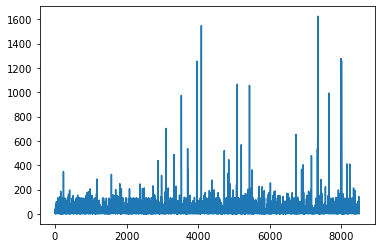

In [132]:
translated_df['Length of Translated_Description Before Summarization'].plot()

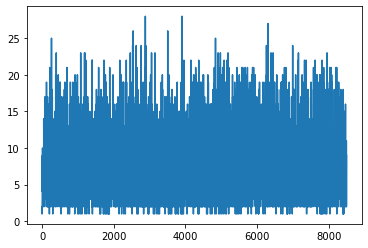

In [133]:
translated_df['Length of Translated_Short description Before Summarization'].plot()

## 6(b). Applying Text Summarization on Translated_Description with more than 150 words

### Testing Out Summarizer feature extractor function

In [134]:
str_me = '''received from: abcdri@company.com windy shi will recall message "ticket_no1564867 - comments added". This message is for the designated recipient to use, which may contain privileged under applicable law, confidentiality and non-disclosure of content. '''

str_me1 ='''  The coronavirus disease is spreading across the country at a rapid pace, but the situation is grim in Maharashtra, Delhi, Tamil Nadu, Haryana, West Bengal, Jammu and Kashmir and Uttar Pradesh.

According to Union health ministry, these states have seen a large number of Covid-19 cases in the last 10 days.

In Delhi, nearly 1,300 cases are being recorded everyday. A fortnight ago, this number was around 1,000. On Thursday, the national capital recorded 1,877 new infections.

In Tamil Nadu, the second worst-affected state after Maharashtra, the single-day spike has nearly doubled from an average 700 to more than 1,300. On Thursday, it registered a record 1,927 Covid-19 cases. There is a three-fold increase in the number of cases in Haryana, and the number has doubled in Jammu and Kashmir, according to health ministry data. There are seven states in the country which have more than 10,000 cases of coronavirus disease.

With the rising number of cases, Uttar Pradesh has now reached the fifth spot on the health ministry’s list of statewise count of Covid-19 cases. The state has registered 201 deaths till May 31. But on Thursday, the Covid-19 fatality count of Uttar Pradesh reached 321.

The nationwide Covid-19 tally neared 2.9 lakh on Thursday with a record one-day increase of nearly 10,000 cases. 
In its morning update, the Union Health Ministry said the total number of confirmed Covid-19 cases has risen to 2,86,579 after a record number of 9,996 cases were reported in 24 hours since Wednesday 8 am.

The death toll also saw a record single-day increase of over 350 fatalities to move closer to the 8,500-mark, more than one-third of which have been recorded in 11 days since June 1 - the day that marked the beginning of a phased exit from most restrictions imposed under a nationwide lockdown with effect from March 25.

The government, however, said the virus infection has not entered the community transmission stage as the lockdown and containment measures prevented a rapid spread.
In its morning update, the Union Health Ministry said the total number of confirmed Covid-19 cases has risen to 2,86,579 after a record number of 9,996 cases were reported in 24 hours since Wednesday 8 am.

The death toll also saw a record single-day increase of over 350 fatalities to move closer to the 8,500-mark, more than one-third of which have been recorded in 11 days since June 1 - the day that marked the beginning of a phased exit from most restrictions imposed under a nationwide lockdown with effect from March 25.

The government, however, said the virus infection has not entered the community transmission stage as the lockdown and containment measures prevented a rapid spread.

In its morning update, the Union Health Ministry said the total number of confirmed Covid-19 cases has risen to 2,86,579 after a record number of 9,996 cases were reported in 24 hours since Wednesday 8 am.

The death toll also saw a record single-day increase of over 350 fatalities to move closer to the 8,500-mark, more than one-third of which have been recorded in 11 days since June 1 - the day that marked the beginning of a phased exit from most restrictions imposed under a nationwide lockdown with effect from March 25.

The government, however, said the virus infection has not entered the community transmission stage as the lockdown and containment measures prevented a rapid spread.

Apart from counting words and characters, our online editor can help you to improve word choice and writing style, and, optionally, help you to detect grammar mistakes and plagiarism. To check word count, simply place your cursor into the text box above and start typing. You'll see the number of characters and words increase or decrease as you type, delete, and edit them. You can also copy and paste text from another program over into the online editor above. The Auto-Save feature will make sure you won't lose any changes while editing, even if you leave the site and come back later. Tip: Bookmark this page now.

Knowing the word count of a text can be important. For example, if an author has to write a minimum or maximum amount of words for an article, essay, report, story, book, paper, you name it. WordCounter will help to make sure its word count reaches a specific requirement or stays within a certain limit.

In addition, WordCounter shows you the top 10 keywords and keyword density of the article you're writing. This allows you to know which keywords you use how often and at what percentages. This can prevent you from over-using certain words or word combinations and check for best distribution of keywords in your writing.

In the Details overview you can see the average speaking and reading time for your text, while Reading Level is an indicator of the education level a person would need in order to understand the words you’re using.

Disclaimer: We strive to make our tools as accurate as possible but we cannot guarantee it will always be so.''' 

In [135]:
str_summr = create_summarized_feature(str_me1)
print(str_summr)

The coronavirus disease is spreading across the country at a rapid pace, but the situation is grim in Maharashtra, Delhi, Tamil Nadu, Haryana, West Bengal, Jammu and Kashmir and Uttar Pradesh.
According to Union health ministry, these states have seen a large number of Covid-19 cases in the last 10 days.
On Thursday, it registered a record 1,927 Covid-19 cases.
There is a three-fold increase in the number of cases in Haryana, and the number has doubled in Jammu and Kashmir, according to health ministry data.
With the rising number of cases, Uttar Pradesh has now reached the fifth spot on the health ministry’s list of statewise count of Covid-19 cases.
But on Thursday, the Covid-19 fatality count of Uttar Pradesh reached 321.
The nationwide Covid-19 tally neared 2.9 lakh on Thursday with a record one-day increase of nearly 10,000 cases.
To check word count, simply place your cursor into the text box above and start typing.
You'll see the number of characters and words increase or decrea

In [136]:
print("Word Count of Data before Summarization was ",len(str_me1.split()))
print("Word Count of Data after Summarization is ", len(str_summr.split()))

Word Count of Data before Summarization was  839
Word Count of Data after Summarization is  204


In [137]:
# If the word count is leass than threshold 
str_summr = create_summarized_feature(str_me)
print(str_summr)

received from: abcdri@company.com windy shi will recall message "ticket_no1564867 - comments added". This message is for the designated recipient to use, which may contain privileged under applicable law, confidentiality and non-disclosure of content. 


In [138]:
print("Word Count of Data before Summarization was ",len(str_me.split()))
print("Word Count of Data after Summarization is ", len(str_summr.split()))

Word Count of Data before Summarization was  33
Word Count of Data after Summarization is  33


## 6(b). Creating a Summarized feature out of Translated_Description

In [139]:
translated_df['Summarized_Translated_Description'] = translated_df['Translated_Description'].apply(create_summarized_feature)

Can't Summarize this sentence as input has only one sentence. Hence, replacing with (Rake + Summarized Value)
Can't Summarize this sentence as input has only one sentence. Hence, replacing with (Rake + Summarized Value)
Can't Summarize this sentence as input has only one sentence. Hence, replacing with (Rake + Summarized Value)
Can't Summarize this sentence as input has only one sentence. Hence, replacing with (Rake + Summarized Value)
Can't Summarize this sentence as input has only one sentence. Hence, replacing with (Rake + Summarized Value)


In [140]:
translated_df['Length of Translated_Description After Summarization'] = translated_df['Summarized_Translated_Description'].apply(lambda x: len(str(x).split()))

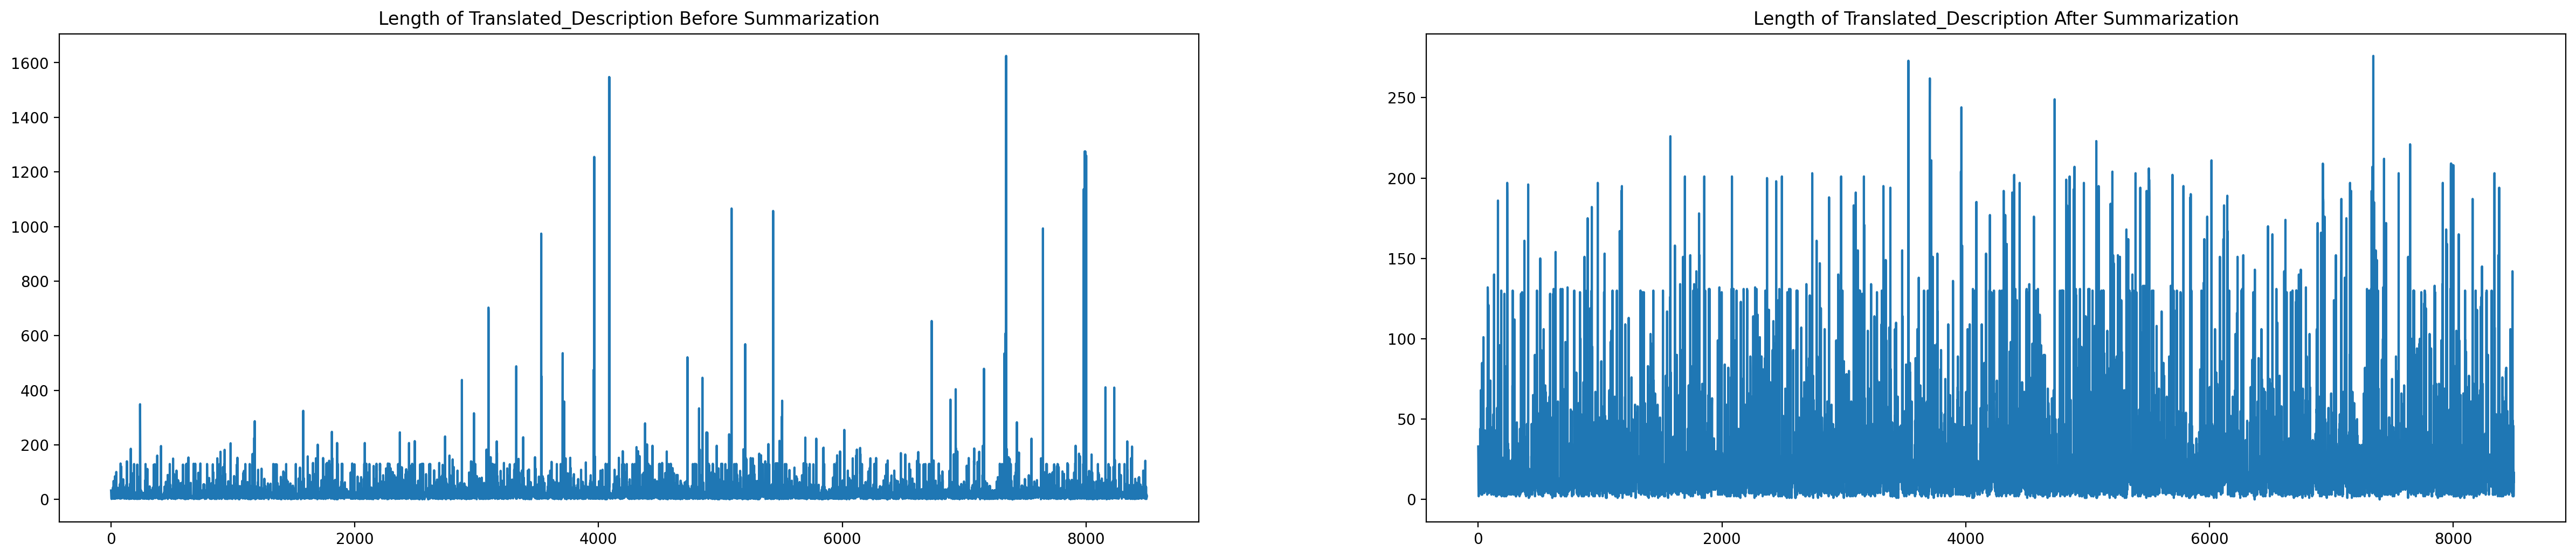

In [141]:
plt.figure(figsize=(30, 6), dpi=200)
plt.subplot(1, 2, 1)
translated_df['Length of Translated_Description Before Summarization'].plot()
plt.title('Length of Translated_Description Before Summarization')

plt.subplot(1, 2, 2)
translated_df['Length of Translated_Description After Summarization'].plot()
plt.title('Length of Translated_Description After Summarization')
plt.show()

In [142]:
translated_df.loc[ translated_df['Summarized_Translated_Description'].apply(lambda x : len(x.split()) > 150) ][['Length of Translated_Description After Summarization', 'Summarized_Translated_Description']]

Length of Translated_Description After Summarization  \
162                                                 186      
238                                                 197      
239                                                 190      
379                                                 161      
410                                                 196      
...                                                 ...      
8046                                                165      
8160                                                187      
8339                                                203      
8371                                                152      
8378                                                194      

                      Summarized_Translated_Description  
162     received from: yfqoaepn.xnezhsit@gmail.com  ...  
238   hi all  we have a connectivity issue between e...  
239   please complete all required questions below.\...  
379     received from: ynsqjehx.kqgrsawl@gmail.com  ...  
410   Myhrt sthry retired as plant manager in usa. i...  
...                                                 ...  
8046  need file restored on a network/nt drive.  1) ...  
8160  received from: qpixeudn.rjlziysd@gmail.com  pl...  
8339  hello team,  could you please unlock account  ...  
8371  from: microsoft on behalf of company inc. [mai...  
8378  just found out that the eccqa certificate is n...  

[141 rows x 2 columns]

# Step 7: Feature Engineering : 'Complete_Description'
----------
Creating a 'Complete_Description' by concatinating 'Translated_Short description' and 'Summarized_Translated_Description' Values  

In [143]:
# Concatenate Short description and Description
translated_df['Complete_Description'] = translated_df['Summarized_Translated_Description'] + " " + translated_df['Translated_Short description']
translated_df.head(10)

Short description  \
0                                        login issue   
1                                            outlook   
2                                 cant log in to vpn   
3                      unable to access hr_tool page   
4                                       skype error    
5     unable to log in to engineering tool and skype   
6  event: critical:HostName_221.company.com the v...   
7  ticket_no1550391- employment status - new non-...   
8               unable to disable add ins on outlook   
9                    ticket update on inplant_874773   

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1  \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
2  \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   
5     unable to log in to engineering tool and skype  eflahbxn ltdgrvkz   
6  event: critical:HostName_221.company.com the v...  jyoqwxhz clhxsoqy   
7  ticket_no1550391- employment status - new non-...  eqzibjhw ymebpoih   
8               unable to disable add ins on outlook  mdbegvct dbvichlg   
9                    ticket update on inplant_874773  fumkcsji sarmtlhy   

  Assignment group                            Raked Short description  \
0            GRP_0                                    ['login issue']   
1            GRP_0                                        ['outlook']   
2            GRP_0                                ['cant log', 'vpn']   
3            GRP_0                  ['access hr_tool page', 'unable']   
4            GRP_0                                    ['skype error']   
5            GRP_0     ['engineering tool', 'unable', 'skype', 'log']   
6            GRP_1  ['mountpoint threshold', 'value', 'sid_37', 'o...   
7            GRP_0  ['new non', 'enter user', 'employment status',...   
8            GRP_0           ['disable add ins', 'unable', 'outlook']   
9            GRP_0                ['ticket update', 'inplant_874773']   

                                   Raked Description Iso_Description  \
0  ['verified user details', 'user name', 'manage...              en   
1  ['somebody please advise', 'com hello team', '...              en   
2  ['vpn best', 'com hi', 'cannot log', 'ybqkwiam...              en   
3                  ['access hr_tool page', 'unable']              en   
4                                    ['skype error']              ja   
5     ['engineering tool', 'unable', 'skype', 'log']              en   
6  ['mountpoint threshold', 'value', 'sr3psa1d_7'...              en   
7  ['new non', 'enter user', 'employment status',...              en   
8           ['disable add ins', 'unable', 'outlook']              en   
9                ['ticket update', 'inplant_874773']              en   

  Language_Description                             Translated_Description  \
0              English  -verified user details.(employee# & manager na...   
1              English    received from: hmjdrvpb.komuaywn@gmail.com  ...   
2              English    received from: eylqgodm.ybqkwiam@gmail.com  ...   
3              English                      unable to access hr_tool page   
4             Japanese                                        skype error   
5              English     unable to log in to engineering tool and skype   
6              English  event: critical:HostName_221.company.com the v...   
7              English  ticket_no1550391- employment status - new non-...   
8              English               unable to disable add ins on outlook   
9              English                    ticket update on inplant_874773   

  Iso_Short description Language_Short description  \
0                    en                    English   
1                    en                

## Finally coverting the df values to str type

In [144]:
# We will use applymap() as it works element-wise on a DataFrame, whereas apply() works on a row / column basis of a DataFrame
translated_df = translated_df.applymap(str)

# Step 8 : Export Translated_df to csv

In [145]:
translated_df.to_csv(r'dataset/Tanslated_Preprocessed_Data_v2.csv', index = False)

In [146]:
translated_df["index"]=translated_df.index.values

In [147]:
translated_df.head(5)

Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1  \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
2  \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group            Raked Short description  \
0            GRP_0                    ['login issue']   
1            GRP_0                        ['outlook']   
2            GRP_0                ['cant log', 'vpn']   
3            GRP_0  ['access hr_tool page', 'unable']   
4            GRP_0                    ['skype error']   

                                   Raked Description Iso_Description  \
0  ['verified user details', 'user name', 'manage...              en   
1  ['somebody please advise', 'com hello team', '...              en   
2  ['vpn best', 'com hi', 'cannot log', 'ybqkwiam...              en   
3                  ['access hr_tool page', 'unable']              en   
4                                    ['skype error']              ja   

  Language_Description                             Translated_Description  \
0              English  -verified user details.(employee# & manager na...   
1              English    received from: hmjdrvpb.komuaywn@gmail.com  ...   
2              English    received from: eylqgodm.ybqkwiam@gmail.com  ...   
3              English                      unable to access hr_tool page   
4             Japanese                                        skype error   

  Iso_Short description Language_Short description  \
0                    en                    English   
1                    en                    English   
2                    en                    English   
3                    en                    English   
4                    ja                   Japanese   

    Translated_Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                    skype error   

  Length of Translated_Description Before Summarization  \
0                                                 33      
1                                                 25      
2                                                 11      
3                                                  5      
4                                                  2      

  Length of Translated_Short description Before Summarization  \
0                                                  2            
1                                                  1            
2                                                  5            
3                                                  5            
4                                                  2            

                   Summarized_Translated_Description  \
0  -verified user details.(employee# & manager na...   
1    received from: hmjdrvpb.komuaywn@gmail.com  ...   
2    received from: eylqgodm.ybqkwiam@gmail.com  ...   
3                      unable to access hr_tool page   
4                                        skype error   

  Length of Translated_Description After Summarization  \
0                                                 33     
1                                                 25     
2                                                 11     
3                                                  5     
4                                                  2     

                                Complete_Description  index  
0  -verified user details.(employee# & manager na...      0  
1    recei

In [148]:
translated_df_Grp0=translated_df[["Assignment group","Translated_Description","Translated_Short description","index"]].where(translated_df["Assignment group"]=="GRP_0")
translated_df_Grp0["Assignment group"].unique()

array(['GRP_0', nan], dtype=object)

In [149]:
translated_df_Grp0.dropna(how="all")


Assignment group                             Translated_Description  \
0               GRP_0  -verified user details.(employee# & manager na...   
1               GRP_0    received from: hmjdrvpb.komuaywn@gmail.com  ...   
2               GRP_0    received from: eylqgodm.ybqkwiam@gmail.com  ...   
3               GRP_0                      unable to access hr_tool page   
4               GRP_0                                        skype error   
...               ...                                                ...   
8488            GRP_0  name:mfeyouli ndobtzpw language: browser:micro...   
8489            GRP_0                                     account locked   
8492            GRP_0                 hr_tool etime option not visitble    
8496            GRP_0                           telephony_software issue   
8497            GRP_0  vip2: windows password reset for tifpdchb pedx...   

                           Translated_Short description   index  
0                                           login issue     0.0  
1                                               outlook     1.0  
2                                    cant log in to vpn     2.0  
3                         unable to access hr_tool page     3.0  
4                                           skype error     4.0  
...                                                 ...     ...  
8488                                 erp account unlock  8488.0  
8489                                     account locked  8489.0  
8492                 hr_tool etime option not visitble   8492.0  
8496                           telephony_software issue  8496.0  
8497  vip2: windows password reset for tifpdchb pedx...  8497.0  

[3976 rows x 4 columns]

In [150]:
translated_df_Grp0=translated_df_Grp0.dropna()
translated_df_Grp0["index"]=translated_df_Grp0["index"].astype(int)
translated_df_Grp0.tail(5)

Assignment group                             Translated_Description  \
8488            GRP_0  name:mfeyouli ndobtzpw language: browser:micro...   
8489            GRP_0                                     account locked   
8492            GRP_0                 hr_tool etime option not visitble    
8496            GRP_0                           telephony_software issue   
8497            GRP_0  vip2: windows password reset for tifpdchb pedx...   

                           Translated_Short description  index  
8488                                 erp account unlock   8488  
8489                                     account locked   8489  
8492                 hr_tool etime option not visitble    8492  
8496                           telephony_software issue   8496  
8497  vip2: windows password reset for tifpdchb pedx...   8497

In [151]:
translated_df_Grp0.shape

(3976, 4)

In [152]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn import cluster 
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering


In [153]:
m=Word2Vec(translated_df_Grp0["Translated_Description"],size=200,min_count=1,sg=1)
def vectorizer(sent,m):
    vec=[]
    numw=0
    for w in sent:
        try:
            if numw==0:
                vec=m[w]
            else:
                vec=np.add(vec,m[w])
            numw+=1
        except:
            pass

        return np.asarray(vec)/numw
l=[]
for i in translated_df_Grp0["Translated_Description"]:
    l.append(vectorizer(i,m))
X=np.array(l)

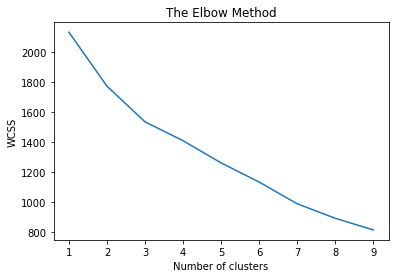

In [154]:
import matplotlib.pyplot as plt
wcss=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [155]:
n_clusters=8
clf=KMeans(n_clusters=n_clusters, max_iter=100,init='k-means++',n_init=1)
labels=clf.fit_predict(X)
print(labels)
for index, sen in enumerate(translated_df_Grp0['Translated_Description']):
    print(str(labels[index])+":"+str(sen))

ived from: jegpvyrh.kasnhdrb@gmail.com  single/sign on for hr_tool oneteam is not working please see screen below.  [cid:image001.png@01d1f181.a1f8SID_310]   
2:erp SID_34 zdsxmcwu thdjzolwronization issue 
4:hello altogether  we have problems with our EU_tool. please open zuteillisten>>>plant_110 >>>>hartbearbeitung>>>>>kantenverrunden>>>>sammelarbpl  then you see this window:                          in the past when we do a doubleklick on eps we could see in a new window our point of measurement for this inserts. but now this function is out of service.      mit freundlichen grüßen / best 
7:password reset request.
2:  received from: wchidyuk.shqbfpuy@gmail.com  hi,  following are the details of guest visiting company india from tomorrow and request you to provigjtyswkb dpvaymxrest wifi access.  sl.no.  guest first name  guest last name  guest email-id  location  company sponsor email-id  access required till (date)  1  sadiertpta  palffs  sadiertpta.palffs@partner.com<mailto:sadier

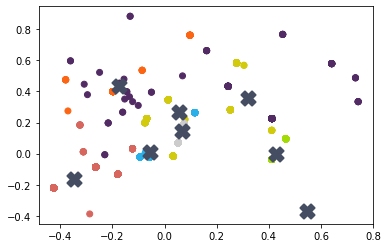

In [156]:
pca=PCA(n_components=5).fit(X)
coords=pca.transform(X)
label_colors=["#2AB0E9", "#2BAF74","#D7665E","#CCCCCC","#D2CA0D","#522A64","#A3DB05","#FC6514"]
colors=[label_colors[i] for i in labels]
plt.scatter(coords[:,0],coords[:,1],c=colors)
centroids=clf.cluster_centers_
centroids_coords=pca.transform(centroids)
plt.scatter(centroids_coords[:,0],centroids_coords[:,1],marker='X',s=200,linewidths=2,c="#444d61")


In [157]:
translated_df_Grp0.head()

Assignment group                             Translated_Description  \
0            GRP_0  -verified user details.(employee# & manager na...   
1            GRP_0    received from: hmjdrvpb.komuaywn@gmail.com  ...   
2            GRP_0    received from: eylqgodm.ybqkwiam@gmail.com  ...   
3            GRP_0                      unable to access hr_tool page   
4            GRP_0                                        skype error   

    Translated_Short description  index  
0                    login issue      0  
1                        outlook      1  
2             cant log in to vpn      2  
3  unable to access hr_tool page      3  
4                    skype error      4

In [158]:
translated_df_Grp0["New Assignment grp"]="0"

In [159]:
translated_df_Grp0["New Assignment grp"].value_counts().to_list()

[3976]

In [160]:
print(labels[2075])

2


In [161]:
a=0
for index_label, row in translated_df_Grp0.iterrows():
    translated_df_Grp0.at[index_label,'New Assignment grp'] = "GRP_0"+"_"+str(labels[a])
    a=a+1
print(a)

3976


In [162]:
translated_df_Grp0.head()

Assignment group                             Translated_Description  \
0            GRP_0  -verified user details.(employee# & manager na...   
1            GRP_0    received from: hmjdrvpb.komuaywn@gmail.com  ...   
2            GRP_0    received from: eylqgodm.ybqkwiam@gmail.com  ...   
3            GRP_0                      unable to access hr_tool page   
4            GRP_0                                        skype error   

    Translated_Short description  index New Assignment grp  
0                    login issue      0            GRP_0_2  
1                        outlook      1            GRP_0_2  
2             cant log in to vpn      2            GRP_0_2  
3  unable to access hr_tool page      3            GRP_0_1  
4                    skype error      4            GRP_0_2

In [163]:
for index_label, row in translated_df_Grp0.iterrows():
   val=translated_df_Grp0.at[index_label,'index']
   val=val.astype(int)
   #print(val)
   translated_df.at[val , 'Assignment group'] = translated_df_Grp0.at[index_label,'New Assignment grp']

In [164]:
translated_df.head(5)

Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1  \n\nreceived from: hmjdrvpb.komuaywn@gmail.com...  hmjdrvpb komuaywn   
2  \n\nreceived from: eylqgodm.ybqkwiam@gmail.com...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group            Raked Short description  \
0          GRP_0_2                    ['login issue']   
1          GRP_0_2                        ['outlook']   
2          GRP_0_2                ['cant log', 'vpn']   
3          GRP_0_1  ['access hr_tool page', 'unable']   
4          GRP_0_2                    ['skype error']   

                                   Raked Description Iso_Description  \
0  ['verified user details', 'user name', 'manage...              en   
1  ['somebody please advise', 'com hello team', '...              en   
2  ['vpn best', 'com hi', 'cannot log', 'ybqkwiam...              en   
3                  ['access hr_tool page', 'unable']              en   
4                                    ['skype error']              ja   

  Language_Description                             Translated_Description  \
0              English  -verified user details.(employee# & manager na...   
1              English    received from: hmjdrvpb.komuaywn@gmail.com  ...   
2              English    received from: eylqgodm.ybqkwiam@gmail.com  ...   
3              English                      unable to access hr_tool page   
4             Japanese                                        skype error   

  Iso_Short description Language_Short description  \
0                    en                    English   
1                    en                    English   
2                    en                    English   
3                    en                    English   
4                    ja                   Japanese   

    Translated_Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                    skype error   

  Length of Translated_Description Before Summarization  \
0                                                 33      
1                                                 25      
2                                                 11      
3                                                  5      
4                                                  2      

  Length of Translated_Short description Before Summarization  \
0                                                  2            
1                                                  1            
2                                                  5            
3                                                  5            
4                                                  2            

                   Summarized_Translated_Description  \
0  -verified user details.(employee# & manager na...   
1    received from: hmjdrvpb.komuaywn@gmail.com  ...   
2    received from: eylqgodm.ybqkwiam@gmail.com  ...   
3                      unable to access hr_tool page   
4                                        skype error   

  Length of Translated_Description After Summarization  \
0                                                 33     
1                                                 25     
2                                                 11     
3                                                  5     
4                                                  2     

                                Complete_Description  index  
0  -verified user details.(employee# & manager na...      0  
1    recei

In [165]:
translated_df.to_csv(r'dataset/Updated_translated_df_Grp_Segregation.csv', index = False)

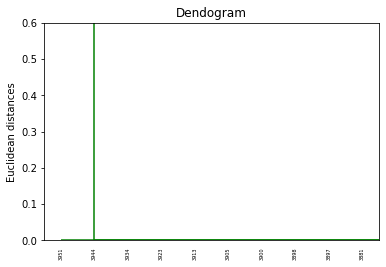

In [83]:
Z=hierarchy.linkage(X,'ward')
dn=hierarchy.dendrogram(Z)
plt.title('Dendogram')
plt.ylabel('Euclidean distances')
plt.xlim(0,100)
plt.ylim(0,0.6)
plt.show()

In [222]:
hc=AgglomerativeClustering(n_clusters=5,affinity='euclidean',linkage='ward')
y_hc=hc.fit_predict(X)
print(y_hc)
for index,sen in enumerate(translated_df_Grp0['Translated_Description']):
    print(str(y_hc[index])+":"+str(translated_df_Grp0['Translated_Description']))



                                      skype error
                              ...                        
8488    name:mfeyouli ndobtzpw language: browser:micro...
8489                                       account locked
8492                   hr_tool etime option not visitble 
8496                             telephony_software issue
8497    vip2: windows password reset for tifpdchb pedx...
Name: Translated_Description, Length: 3976, dtype: object
0:0       -verified user details.(employee# & manager na...
1         received from: hmjdrvpb.komuaywn@gmail.com  ...
2         received from: eylqgodm.ybqkwiam@gmail.com  ...
3                           unable to access hr_tool page
4                                             skype error
                              ...                        
8488    name:mfeyouli ndobtzpw language: browser:micro...
8489                                       account locked
8492                   hr_tool etime option not visitble 
8496                

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns
# Eliminate categories with fewer than 100 tickets
classifier = "Translated_Short description"
ticket_threshold = 100
df_classifiers = translated_df_Grp0[translated_df_Grp0.groupby(translated_df_Grp0[classifier].Transform())]

AttributeError: 'Series' object has no attribute 'Transform'

# Step 9: Prepping Dataframe for Model Building

## 9(a). Target Feature : Label Encoding

In [63]:
translated_df['Assignment group'].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

### NOTE : We can see above all the values in Target feature 'Assignment group' are Catagorical in nature. Hence, will be Encoding them to a machine readable form via Label Encoding

In [64]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
translated_df['Assignment group LabelEncode']= label_encoder.fit_transform(translated_df['Assignment group']) 
  
translated_df['Assignment group LabelEncode'].unique()

array([ 0,  1, 23, 34, 45, 56, 67, 72, 73,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28,
       29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 26, 59, 60, 61, 62, 63, 64,
       65, 66, 68, 69, 70, 71])

In [65]:
label_encoded_dict = dict(zip(translated_df['Assignment group'].unique(), translated_df['Assignment group LabelEncode'].unique()))

In [66]:
len(label_encoded_dict)

74

# Step 10 : Feature Extractions:
### * A problem with modeling text is that it is messy, and techniques like machine learning algorithms prefer well defined fixed-length inputs and outputs. <br>
### * Machine learning algorithms cannot work with raw text directly; the text must be converted into numbers. Specifically, vectors of numbers. <br>
### * This is called feature extraction or feature encoding.<br>
-------------- 
#  We will be using the following feature Extraction to transform Input features before feeding it into model : <br>
### (a). BoW :: Bag of Words <br>
### (b). Tf-Idf :: Term Frequency - Inverse Document Frequency <br>
### (c). Topic Modelling <br>
### (d). Document Clustering<br>
### (e). Word Embedding
-------------

# 10(a). Feature Extraction : Bag of Words

In [67]:
# For BoW we are using CountVectorizer for creating Document Vectors
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer(max_features = 2000)

X_BoW = CV.fit_transform(translated_df['Complete_Description']).toarray()
y = translated_df['Assignment group LabelEncode']

print("Shape of Input Feature :",np.shape(X_BoW))
print("Shape of Target Feature :",np.shape(y))

Shape of Input Feature : (8500, 2000)
Shape of Target Feature : (8500,)


In [68]:
# Splitting Train Test 
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X_BoW, y, test_size=0.3, random_state = 5)

## Finding out if Train Test split was uniform for all Target Labels(or not)
--------
### * We will find out labels that model hasn't trained on (absent in training data), as it can't possibly correctly predict that absent label in test data.
### * This will give us a idea on upscalling specific labels in Target Feature.

In [69]:
# Check which labels are not uniformly distributed after train_test split
check_label_split(train_y, test_y, label_encoded_dict)

The following Target Labels are missing from Test Data : 

GRP_35
GRP_38
GRP_55
GRP_57
GRP_61
GRP_63
GRP_64
GRP_66
GRP_68
GRP_69
GRP_72
GRP_73

The following Target Labels are missing from Train Data :
GRP_67
GRP_70


## Applying ML Classifiers
--------------
### SVM Classifier

In [70]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear').fit(train_x, train_y)
y_pred = svm_clf.predict(test_x)

In [71]:
from sklearn.metrics import accuracy_score, f1_score

acc_score = accuracy_score(test_y, y_pred)
print("SVM-Linear Score for BoW Model is ", acc_score)

f_sc = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("SVM F1 Score for BoW Model is ", f_sc)

SVM-Linear Score for BoW Model is  0.6423529411764706
SVM F1 Score for BoW Model is  0.6219942106271076


## LightGBM Multiclass Classifier

In [72]:
import lightgbm as lgb


#Parameters
params = {
          "objective" : "multiclass",
          "num_class" : 74,
          "num_leaves" : 60,
          "max_depth": -1,
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2018,
          "verbosity" : -1 }

lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(test_x, test_y, reference=lgb_train)

In [73]:
print("Training LightGBM for Bag of Words")

lgbmodel = lgb.train(params, 
                    lgb_train, 
                    2000, 
                    valid_sets=[lgb_train, lgb_eval], 
                    early_stopping_rounds=100, 
                    verbose_eval=200)

Training LightGBM for Bag of Words
Training until validation scores don't improve for 100 rounds
[200]	training's multi_logloss: 0.799422	valid_1's multi_logloss: 1.49256
[400]	training's multi_logloss: 0.412878	valid_1's multi_logloss: 1.37726
Early stopping, best iteration is:
[470]	training's multi_logloss: 0.338243	valid_1's multi_logloss: 1.37167


In [74]:
y_pred_lgmb_BoW = lgbmodel.predict(test_x, num_iteration = lgbmodel.best_iteration)

In [75]:
lgbmodel.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('multi_logloss', 0.33824270723138905)]),
             'valid_1': OrderedDict([('multi_logloss', 1.3716730585406127)])})

In [76]:
#print(y_pred_lgmb[0])

y_pred = [np.argmax(line) for line in y_pred_lgmb_BoW] # Turn probability to 0-1 binary output

#print("\n",y_pred[0])

In [77]:
from sklearn.metrics import accuracy_score, f1_score

acc_score_lgbm_BoW = accuracy_score(test_y, y_pred)
print("LightGBM-Multiclass Classifier's Acc Score for BoW Model is ", acc_score_lgbm_BoW)

f_sc_lgbm_BoW = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("LightGBM-Multiclass Classifier's F1 Score for BoW Model is ", f_sc_lgbm_BoW)

LightGBM-Multiclass Classifier's Acc Score for BoW Model is  0.6564705882352941
LightGBM-Multiclass Classifier's F1 Score for BoW Model is  0.6176942902347089


# 10(b). Feature Extraction : Tf-Idf (Term Frequency - Inverse Document Frequency)

In [78]:
# For Tf-Idf we are using CountVectorizer for creating Document Vectors
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(max_features = 2000)

X_tf_idf = tfidf.fit_transform(translated_df['Complete_Description']).toarray()
#richa 
X_tf_idf_Clus=tfidf.fit_transform(translated_df['Complete_Description'])
y = translated_df['Assignment group LabelEncode']

print("Shape of Input Feature :",np.shape(X_tf_idf))
print("Shape of Target Feature :",np.shape(y))

Shape of Input Feature : (8500, 2000)
Shape of Target Feature : (8500,)


In [79]:
# Splitting Train Test 
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X_tf_idf, y, test_size=0.3, random_state = 1)

### Finding out if Train Test split was uniform for all Target Labels(or not)

In [80]:
# Check which labels are not uniformly distributed after train_test split
check_label_split(train_y, test_y, label_encoded_dict)

The following Target Labels are missing from Test Data : 

GRP_35
GRP_53
GRP_54
GRP_61
GRP_64
GRP_67
GRP_69
GRP_70
GRP_72

The following Target Labels are missing from Train Data :
GRP_73


## Clustering

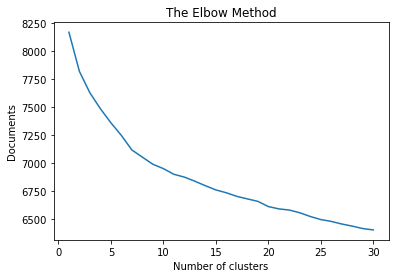

In [117]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,31):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X_tf_idf)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,31),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Documents')
#plt.savefig('elbow.png')
plt.show()

## Applying ML Classifiers
--------------
### SVM Classifier

In [82]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear').fit(train_x, train_y)
y_pred = svm_clf.predict(test_x)

In [83]:
acc_score_svm_tfidf = accuracy_score(test_y, y_pred)
print("SVM-Linear Score for Tf-Idf Model is ", acc_score_svm_tfidf)

f_sc_svm_tfidf = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("SVM F1 Scorefor Tf-Idf Model is ", f_sc_svm_tfidf)

SVM-Linear Score for Tf-Idf Model is  0.66
SVM F1 Scorefor Tf-Idf Model is  0.6356432611929831


## LightGBM Multiclass Classifier

In [84]:
#Parameters
params = {
          "objective" : "multiclass",
          "num_class" : 74,
          "num_leaves" : 60,
          "max_depth": -1,
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2018,
          "verbosity" : -1 }

lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(test_x, test_y, reference=lgb_train)

In [85]:
print("Training LightGBM for Tf-Idf")

lgbmodel = lgb.train(params, 
                    lgb_train, 
                    2000, 
                    valid_sets=[lgb_train, lgb_eval], 
                    early_stopping_rounds=100, 
                    verbose_eval=200)

Training LightGBM for Tf-Idf
Training until validation scores don't improve for 100 rounds
[200]	training's multi_logloss: 0.65686	valid_1's multi_logloss: 1.59715
[400]	training's multi_logloss: 0.287419	valid_1's multi_logloss: 1.51305
Early stopping, best iteration is:
[398]	training's multi_logloss: 0.289605	valid_1's multi_logloss: 1.51297


In [86]:
y_pred_lgmb_TfIdf = lgbmodel.predict(test_x, num_iteration = lgbmodel.best_iteration)

In [87]:
y_pred = [np.argmax(line) for line in y_pred_lgmb_TfIdf] # Turn probability to 0-1 binary output

In [88]:
from sklearn.metrics import accuracy_score, f1_score

acc_score_lgbm_TfIdf = accuracy_score(test_y, y_pred)
print("LightGBM-Multiclass Classifier's Acc Score for Tf-Idf Model is ", acc_score_lgbm_TfIdf)

f_sc_lgbm_TfIdf = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("LightGBM-Multiclass Classifier's F1 Score for Tf-Idf Model is ", f_sc_lgbm_TfIdf)

LightGBM-Multiclass Classifier's Acc Score for Tf-Idf Model is  0.636078431372549
LightGBM-Multiclass Classifier's F1 Score for Tf-Idf Model is  0.5978424372253176


# 10(c). Feature Extraction : Topic Modelling (LDA Approach/Algo)

In [89]:
# Creates a dictionary of Token --> Token_Id
from gensim.corpora import Dictionary

# model imports
from gensim.models.ldamulticore import LdaMulticore


## Feature Engineering: 'Text' for LDA

In [90]:
# Concatenate Short description and Description
translated_df['text'] = translated_df['Translated_Description'] + " " + translated_df['Translated_Short description']
translated_df['text'].astype(str)

0       -verified user details.(employee# & manager na...
1         received from: hmjdrvpb.komuaywn@gmail.com  ...
2         received from: eylqgodm.ybqkwiam@gmail.com  ...
3       unable to access hr_tool page unable to access...
4                                 skype error skype error
                              ...                        
8495      received from: avglmrts.vhqmtiua@gmail.com  ...
8496    telephony_software issue telephony_software issue
8497    vip2: windows password reset for tifpdchb pedx...
8498    i am unable to access the machine utilities to...
8499    various prgramdntyme can not be opened on mult...
Name: text, Length: 8500, dtype: object

## Preprocessing before LDA

In [91]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [92]:
our_special_word = 'qwerty'

def remove_ascii_words(df):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'text'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'text'] = df.loc[i, 'text'].replace(word, our_special_word)
    return non_ascii_words

non_ascii_words = remove_ascii_words(translated_df)

In [93]:
def lda_get_good_tokens(translated_df):
    translated_df['text'] = translated_df.text.str.lower()
    translated_df['tokenized_text'] = list(map(nltk.word_tokenize, translated_df.text))
    translated_df['tokenized_text'] = list(map(get_good_tokens, translated_df.tokenized_text))

In [94]:
def remove_stopwords(translated_df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    translated_df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       translated_df['tokenized_text']))

In [95]:
def stem_words(translated_df):
    lemm = nltk.stem.WordNetLemmatizer()
    translated_df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     translated_df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    translated_df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  translated_df.lemmatized_text))

## Create a dictionary for the model: <br>
Since a computer can't reallly understand what a word means, we need to transform it into some number the model will be able to work with. We use gensim.corpora.Dictionary for this.

In [96]:
dictionary = Dictionary(documents=translated_df.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

AttributeError: 'DataFrame' object has no attribute 'stemmed_text'

In [97]:
#Make a BOW for every document
def document_to_bow(translated_df):
    translated_df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), translated_df.stemmed_text))

In [98]:
def lda_preprocessing(translated_df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(translated_df)
    remove_stopwords(translated_df)
    stem_words(translated_df)
    document_to_bow(translated_df)

In [99]:
lda_preprocessing(translated_df)

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\Zenbook/nltk_data'
    - 'C:\\Program Files (x86)\\Microsoft Visual Studio\\Shared\\Python37_64\\nltk_data'
    - 'C:\\Program Files (x86)\\Microsoft Visual Studio\\Shared\\Python37_64\\share\\nltk_data'
    - 'C:\\Program Files (x86)\\Microsoft Visual Studio\\Shared\\Python37_64\\lib\\nltk_data'
    - 'C:\\Users\\Zenbook\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


# LDA training

In [100]:
corpus = translated_df.bow

AttributeError: 'DataFrame' object has no attribute 'bow'

In [101]:
%%time
num_topics = 20
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

NameError: name 'corpus' is not defined

In [102]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

translated_df['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      translated_df.bow))

AttributeError: 'DataFrame' object has no attribute 'bow'

In [103]:
translated_df['lda_features']

KeyError: 'lda_features'

## Utilizing lda_features as X and doing train_test split

In [104]:


X_lda = translated_df['lda_features']
y = translated_df['Assignment group LabelEncode']

print("Shape of Input Feature :",np.shape(X_tf_idf))
print("Shape of Target Feature :",np.shape(y))

KeyError: 'lda_features'

In [105]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X_tf_idf, y, test_size=0.3, random_state = 1)

In [106]:
# Check which labels are not uniformly distributed after train_test split
check_label_split(train_y, test_y, label_encoded_dict)

The following Target Labels are missing from Test Data : 

GRP_35
GRP_53
GRP_54
GRP_61
GRP_64
GRP_67
GRP_69
GRP_70
GRP_72

The following Target Labels are missing from Train Data :
GRP_73


In [107]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear').fit(train_x, train_y)
y_pred = svm_clf.predict(test_x)

In [108]:
acc_score_svm_lda = accuracy_score(test_y, y_pred)
print("SVM-Linear Score for LDA Model is ", acc_score_svm_lda)

f_sc_svm_lda = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("SVM F1 Scorefor LDA Model is ", f_sc_svm_lda)

SVM-Linear Score for LDA Model is  0.66
SVM F1 Scorefor LDA Model is  0.6356432611929831


## LightGBM Multiclass Classifier

In [109]:
#Parameters
params = {
          "objective" : "multiclass",
          "num_class" : 74,
          "num_leaves" : 60,
          "max_depth": -1,
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2018,
          "verbosity" : -1 }

lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(test_x, test_y, reference=lgb_train)

In [110]:
print("Training LightGBM for Tf-Idf")

lgbmodel = lgb.train(params, 
                    lgb_train, 
                    2000, 
                    valid_sets=[lgb_train, lgb_eval], 
                    early_stopping_rounds=100, 
                    verbose_eval=200)

Training LightGBM for Tf-Idf
Training until validation scores don't improve for 100 rounds
[200]	training's multi_logloss: 0.65686	valid_1's multi_logloss: 1.59715
[400]	training's multi_logloss: 0.287419	valid_1's multi_logloss: 1.51305
Early stopping, best iteration is:
[398]	training's multi_logloss: 0.289605	valid_1's multi_logloss: 1.51297


In [111]:
y_pred_lgmb_lda = lgbmodel.predict(test_x, num_iteration = lgbmodel.best_iteration)

In [112]:
y_pred_lda = [np.argmax(line) for line in y_pred_lgmb_lda] # Turn probability to 0-1 binary output

In [113]:
acc_score_lgbm_lda = accuracy_score(test_y, y_pred_lda)
print("LightGBM-Multiclass Classifier's Acc Score for Tf-Idf Model is ", acc_score_lgbm_lda)

f_sc_lgbm_lda = f1_score(test_y, y_pred_lda, average='weighted', labels=np.unique(y_pred_lda))
print("LightGBM-Multiclass Classifier's F1 Score for Tf-Idf Model is ", f_sc_lgbm_lda)

LightGBM-Multiclass Classifier's Acc Score for Tf-Idf Model is  0.636078431372549
LightGBM-Multiclass Classifier's F1 Score for Tf-Idf Model is  0.5978424372253176
